In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html

## Analise de UPAC com bateria

Analise de um projecto de UPAC com dados de consumo obtidos do portal e-redes, dados de produção obtidos da plataforma PVGIS e subsequente análise dos indicadores principais do projecto: indice auto consumo (IAC), indice de auto suficiência (IAS) e indice entrega à rede (IER). É feita também uma análise financeiro do projecto.

#### Indice:
##### 1. Consumo
##### 2. Produção
##### 3. Análise Energética Projecto
##### 4. Análise Poupança Anual
##### 5. Análise Financeiro Projecto

In [23]:
# Parametros do projecto
nome_projecto = 'Exemplo_600W'
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 2400 # kWh, exemplo consumo médio 200 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
capacidade_instalada = 0.6 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
ano_pvgis_db = 2020 # ultimo ano disponivel PVGIS-SARAH2 na V5.2
lat = 38.716
lon = -9.148
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Analise energetica
# =====================
analise_com_bateria = True
capacidade_bat = 1.2 # kWh
soc_min = 20 # limite maximo descarregamento em % 
soc_max = 80 # limite maximo carregamento em %

# =====================
# Analise poupanca anual
# =====================
ano_tarifario = 2023
simples_kwh = 0.15826 # simples
bihorario_fora_vazio_kwh = 0.1859
bihorario_vazio_kwh = 0.0988
trihorario_ponta_kwh = 0.2278
trihorario_cheias_kwh = 0.1638
trihorario_vazio_kwh = 0.0988
# venda a rede com preco fixo
preco_venda_rede = 0.06 # 6cent/kWh
precos_energia = ape.TarifarioEnergia(simples_kwh, \
    bihorario_fora_vazio_kwh, bihorario_vazio_kwh, \
    trihorario_ponta_kwh, trihorario_cheias_kwh, trihorario_vazio_kwh, \
    preco_venda_rede)

# =====================
# Analise tempo de vida
# =====================
tempo_vida = 25 # anos
ano_0 = 2023 # ano 0 do projecto
taxa_actualizacao = 5 # em %
taxa_degradacao_sistema = 0.7 # %/ano
taxa_inflacao = 2.0 # %/ano

# Custos do projecto
total = 1500 # €
# investimento_estimado = pv + instalacao + outros_custos
custo_pv = total * 0.6 # 60% material
custo_instalacao = total * 0.3 # 30% instalacao
outros_custos = total * 0.1 # 10% outros custos
# custo manutencao anual como percentagem do investimento
perc_custo_manutencao = 0.5 # em %
# apoio estatal (fundo ambiental)
considerar_apoio = False
perc_apoio = 85 # em % do investimento estimado
apoio_max = 2500 # em €, valor maximo pago pelo fundo

### 1. Consumo

Utilização de perfil médio da e-redes

In [24]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 2400.0 kWh


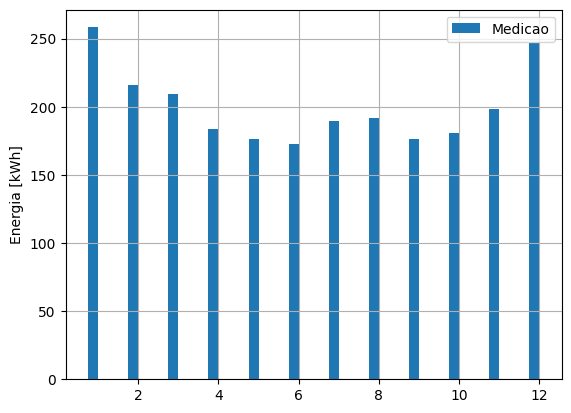

In [25]:
resultados_mensais = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(resultados_mensais.index.month-width/2, resultados_mensais, width=width, label='Medicao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

### 2. Produção

Produção estimada através do PV GIS

In [26]:
producao = pvgis.get_pvgis_hourly(lat, lon, ano_pvgis_db, ano_pvgis_db, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao = seriesprod.converter_pvgis_data(producao, ano_producao)

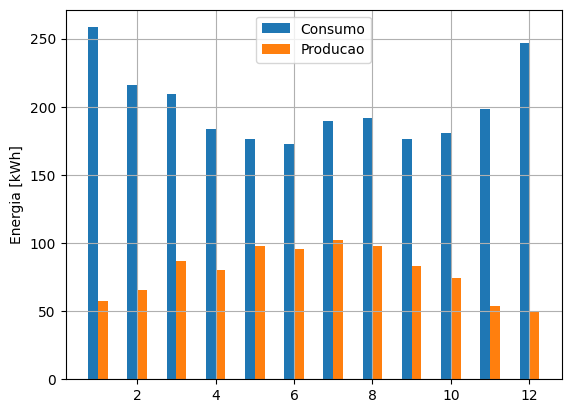

In [27]:
producao_mensal = producao.resample('M').sum()

width = 0.25
plt.bar(resultados_mensais.index.month-width/2, resultados_mensais, width=width, label='Consumo')
plt.bar(producao_mensal.index.month+width/2, producao_mensal['autoproducao'], width=width, label='Producao')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

### 3. Análise Energético do Projecto

Considerar sistema de armazenamento com estado de carga (SOC) minimo de 20% e máximo de 80% para maximizar tempo de vida da bateria. 

In [28]:
energia_armaz = []

if analise_com_bateria:
    bat = bateria.bateria(capacidade_bat, soc_min, soc_max)

    # data frames com armazenamento
    energia_armaz = consumo['consumo'].to_frame('consumo')
    energia_armaz = energia_armaz.join(producao, how="outer")

    energia_armaz = ae.analisa_upac_com_armazenamento(energia_armaz, bat)

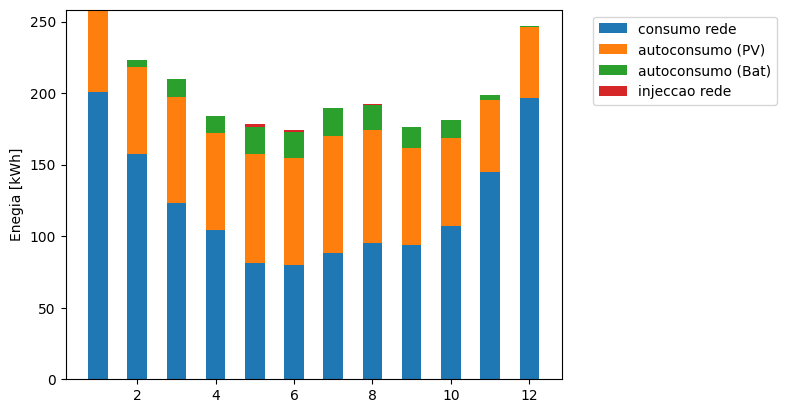

In [29]:
if analise_com_bateria:
    energia_armaz_mensal = energia_armaz.resample('M').sum()

    width = 0.5
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["consumo_rede"], width=width, label='consumo rede')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["consumo_pv"], width=width, bottom=energia_armaz_mensal["consumo_rede"], label='autoconsumo (PV)')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["descarga_bateria"], width=width, bottom=energia_armaz_mensal["consumo_rede"]+energia_armaz_mensal["consumo_pv"], label='autoconsumo (Bat)')
    plt.bar(energia_armaz_mensal.index.month, energia_armaz_mensal["injeccao_rede"], width=width, bottom=energia_armaz_mensal["consumo_rede"]+energia_armaz_mensal["consumo_pv"]+energia_armaz_mensal["descarga_bateria"], label='injeccao rede')
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    plt.ylabel('Enegia [kWh]')

In [30]:
if analise_com_bateria:
    indicadores_armaz = ae.calcula_indicadores_autoconsumo_com_armazenamento(energia_armaz, bat, capacidade_instalada)
    indicadores_armaz.print_html()

### 4. Análise de poupanca anual

Custos mensais por tipo tarifario.

#### 4.1 UPAC sem venda à rede

In [31]:
if analise_com_bateria:
    # custos tarifario simples
    mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, False)
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, False)
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

    mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, False, ano_tarifario)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_style._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca
mes,,,
Janeiro,52.07 €,40.87 €,11.20 €
Fevereiro,45.31 €,32.51 €,12.80 €
Março,42.53 €,25.66 €,16.87 €
Abril,37.54 €,21.91 €,15.63 €
Maio,35.99 €,17.74 €,18.25 €
Junho,35.41 €,17.43 €,17.98 €
Julho,38.55 €,19.01 €,19.54 €
Agosto,39.07 €,20.28 €,18.79 €
Setembro,36.01 €,19.99 €,16.02 €


#### 4.2 UPAC com venda à rede

In [32]:
if analise_com_bateria:
    # simples
    mensal_simples = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Simples, precos_energia, True)
    simples_styler = mensal_simples.style.format("{:.2f} €").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

    mensal_bihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Bihorario, precos_energia, True)
    bihorario_styler = mensal_bihorario.style.format("{:.2f} €").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

    mensal_trihorario = af.analise_poupanca_anual_fatura(energia_armaz, ape.Tarifario.Trihorario, precos_energia, True, ano_tarifario)
    trihorario_style = mensal_trihorario.style.format("{:.2f} €").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")
    display_html(simples_styler._repr_html_() + bihorario_styler._repr_html_() + trihorario_style._repr_html_(), raw=True)

,fatura sem upac,fatura com upac,poupanca,venda a rede
mes,,,,
Janeiro,52.07 €,40.87 €,11.20 €,0.00 €
Fevereiro,45.31 €,32.51 €,12.80 €,0.00 €
Março,42.53 €,25.66 €,16.89 €,0.02 €
Abril,37.54 €,21.91 €,15.65 €,0.02 €
Maio,35.99 €,17.74 €,18.39 €,0.14 €
Junho,35.41 €,17.43 €,18.05 €,0.07 €
Julho,38.55 €,19.01 €,19.58 €,0.04 €
Agosto,39.07 €,20.28 €,18.82 €,0.03 €
Setembro,36.01 €,19.99 €,16.03 €,0.01 €


## 5. Analise Financeira do projecto no tempo de vida

Calcular indicadores financeiros para o tempo de vida do projecto.

* VAL

* TIR

* Tempo retorno projecto

In [33]:
investimento_estimado = custo_pv + custo_instalacao + outros_custos

# Custo de manutencao anual
custo_manutencao = investimento_estimado * (perc_custo_manutencao / 100)

# Apoio fundo ambiental
apoio = 0
if considerar_apoio:
   apoio = min(investimento_estimado*(perc_apoio/100), apoio_max)
   investimento_estimado = investimento_estimado - apoio

#### 5.1 UPAC sem venda à rede

In [34]:
# custos tarifario simples
indicadores_financas_simples, cf_simples = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Simples, precos_energia, False, indicadores_armaz)
simples_style = indicadores_financas_simples.as_frame().style.format("{:.2f}").set_caption('Tarifario Simples').set_table_attributes("style='display:inline'")

# custos tarifario bi-horario
indicadores_financas_bihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Bihorario, precos_energia, False, indicadores_armaz)
bihorario_style = indicadores_financas_bihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Bi-horário').set_table_attributes("style='display:inline'")

# custos tarifario tri-horario
indicadores_financas_trihorario, _ = af.analise_financeira_projecto_faturas(energia_armaz, investimento_estimado, custo_manutencao, taxa_actualizacao, ano_0, tempo_vida, taxa_degradacao_sistema, taxa_inflacao, ape.Tarifario.Trihorario, precos_energia, False, indicadores_armaz)
trihorario_style = indicadores_financas_trihorario.as_frame().style.format("{:.2f}").set_caption('Tarifario Tri-horário').set_table_attributes("style='display:inline'")

display_html(simples_style._repr_html_() + bihorario_style._repr_html_() + trihorario_style._repr_html_(), raw=True)

,valores
indice,
Tempo vida util projecto [anos],25.00
Custo instalação [€],1500.00
Custo manutenção anual [€/ano],7.50
VAL [€],1303.24
TIR [%],12.04
Retorno do investimento [anos],10.60
Lcoe [€/kWh],0.13
,valores
indice,
